In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()
tavily.invoke("Provide me the recent AI news for June 14, 2025")

[{'title': "Today's Top Tech & AI News at a Glance — June 14, 2025 - Medium",
  'url': 'https://medium.com/@delhi.satish/todays-top-tech-ai-news-at-a-glance-june-14-2025-f530a06d26d6',
  'content': '**Multiverse Computing raises $215 million for CompactifAI**  \n**Summary:** Spanish startup Multiverse Computing closed a €189 million Series B round to advance “CompactifAI,” its platform aimed at slashing the computational costs of large-scale AI workloads.  \n***Why it matters:*** *By reducing the cost barrier for training and running AI models, CompactifAI could democratize access to advanced AI, especially for research institutions and mid-sized firms.* [...] **Google to split from Scale AI after Meta’s big stake**  \n**Summary:** Google, Scale AI’s largest customer, plans to sever ties following Meta’s $14.8 billion deal for a 49% stake in the data-labeling startup, over concerns about sharing proprietary training data with a rival.  \n***Why it matters:*** *As Meta poaches Scale AI’

In [5]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.3-70b-versatile")

In [ ]:
### Custom Functions
def clean_dataframe(df):
    """
    Cleans a dataframe by:
    1. Identifying the row that contains year values (both integer and float).
    2. Renaming columns using the detected years.
    3. Removing metadata rows above the detected year row.
    4. Ensuring all columns have valid names.
    5. Filling NaN values with -inf.
    
    Parameters:
    df (pd.DataFrame): Raw dataframe with metadata and financial data.
    
    Returns:
    pd.DataFrame: Processed dataframe with correct column names and missing values replaced.
    """
    
    # Identify the row index where the first numeric year appears
    year_row_index = None
    for i in range(len(df)):
        non_null_values = df.iloc[i].dropna()
        if non_null_values.astype(str).str.match(r'^\d{4}(\.0)?$').all():  # Matches years like 2024 and 2024.0
            year_row_index = i
            break

    if year_row_index is None:
        raise ValueError("No year row found in the dataset.")

    # Extract column names from the identified row (convert floats to int for clean column names)
    new_columns = df.iloc[year_row_index+1].values.astype(str).tolist()
    new_columns = [col if not col.replace('.0', '').isdigit() else str(int(float(col))) for col in new_columns]

    # Ensure the first column has a proper name (e.g., "Category")
    new_columns[0] = "category"

    # Remove metadata rows above the detected year row and reset index
    df = df.iloc[year_row_index+2:,]

    # Assign new column names
    df.columns = new_columns # 

    # Fill NaN values with -inf
    df = df.fillna(-np.inf).reset_index(drop=True, inplace=False)
    df.set_index('category', inplace=True)
    
    return df

def extract_vals_from_df(df, col, year):
    return float(df.loc[col, year])

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

tools=[tavily, add, multiply, divide]

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

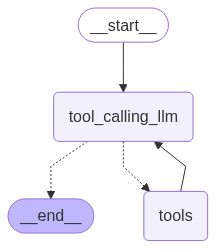

In [9]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

In [13]:
messages = graph.invoke({"messages": HumanMessage(content="Provide me the top 10 most expensive cities in the USA by average monthly cost for 2025. Average them")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 most expensive cities in the USA by average monthly cost for 2025. Average them
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cpsdn5fhf)
 Call ID: cpsdn5fhf
  Args:
    query: top 10 most expensive cities in the USA by average monthly cost for 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "10 Most Expensive Cities in the U.S. (2025) | ConsumerAffairs®", "url": "https://www.consumeraffairs.com/finance/most-expensive-cities-in-the-us.html", "content": "2. San Francisco\n\nSan Francisco, California, is a close second on our list, surpassing San Jose in median real estate taxes ($8,545) and home values ($1,306,400) but being slightly less onerous in terms of median monthly housing costs ($2,337) and gross rent ($2,167). However,